This notebook contains scripts which evaluate the performance of a classification model on the test set.

In [1]:
from train_classifier import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import gaussian_kde
import numpy as np

Start by loading the fine-tuned model and the test dataset.

In [2]:
model_dir = '../data/overflow/BERT'
model, collate_fn = get_bert_model(model_dir)
test_dataset = mongo_dataset.MongoDataset().get_partition('classification_test', projection)

Use Huggingface's Trainer interface to make predictions on the test set.

In [3]:
train_args = TrainingArguments(**default_training_args)
trainer = Trainer(model=model, args=train_args, data_collator=collate_fn)
predictions = trainer.predict(test_dataset)

Convert this output into a pandas dataframe so it's easier to work with.

In [4]:
probs = softmax(predictions.predictions, axis=1)[:,1]
labels = predictions.label_ids.astype(bool)
df = pd.DataFrame(zip(probs, labels), columns=['AnswerProbability', 'Answered'])
df['Title'] = pd.DataFrame(test_dataset).Title

Plot the distributions of predicted probabilities for the two classes (answered and unanswered questions).

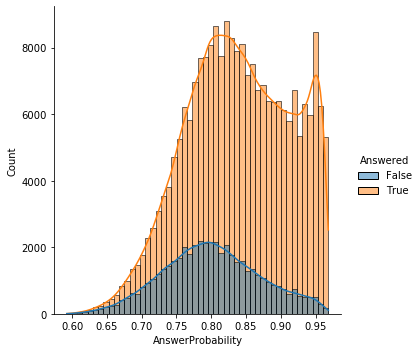

In [5]:
sns.displot(df,x='AnswerProbability', bins=50, hue='Answered', kde=True);

Because we'd like to interpret the model's output as a probability of getting an answer, it is important to verify that the probabilities are calibrated. This means, for example, that if we choose 100 titles to which the model assigned a probability of ~90%, approximately 90/100 of those should actually be answered. Poorly calibrated probabilities can be a sign of overfitting.

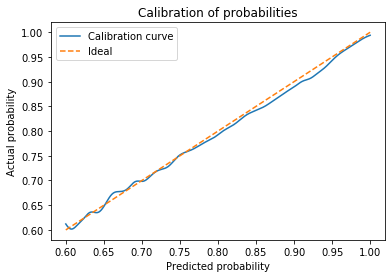

In [6]:
width = 0.1
class_ratio = 1/df.Answered.mean() - 1
kde0 = gaussian_kde(df.AnswerProbability[~df.Answered],width)
kde1 = gaussian_kde(df.AnswerProbability[df.Answered],width)
p_up = np.linspace(0.60,1,1000)
plt.plot(p_up,1/(class_ratio*kde0(p_up)/kde1(p_up)+1))
plt.plot(p_up,p_up,linestyle='dashed')
plt.xlabel('Predicted probability');
plt.ylabel('Actual probability');
plt.title('Calibration of probabilities');
plt.legend(['Calibration curve', 'Ideal']);

Due to the class imbalance, accuracy is not an effective metric (the model would maximize accuracy by predicting that every question is answered). Instead, the ROC curve and ROC-AUC score are a better metric for model performance.

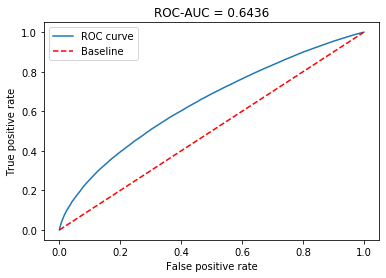

In [7]:
score = roc_auc_score(labels, probs)
fpr, tpr, thresholds = roc_curve(labels, probs)
plt.plot(fpr,tpr);
plt.plot(fpr,fpr, color='red', linestyle='dashed');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.legend(['ROC curve', 'Baseline']);
plt.title(f'ROC-AUC = {score:.4f}');

To better understand what makes a title good or bad, it's helpful to examine questions which the model considers most and least likely to be answered.

In [8]:
num_examples = 10
# Sample from the bottom 5% of titles
bottom_quantile = df.AnswerProbability.quantile(0.05)
bad_titles = df.Title[df.AnswerProbability<=bottom_quantile].sample(num_examples)
# Sample from the top 5% of titles
top_quantile = df.AnswerProbability.quantile(0.95)
good_titles = df.Title[df.AnswerProbability>=top_quantile].sample(num_examples)
# Print the examples
print(f'Most likely to be answered (>{top_quantile:.0%} chance):')
for title in good_titles:
    print('    '+title)
print()    
print(f'Least likely to be answered (<{bottom_quantile:.0%} chance):')
for title in bad_titles:
    print('    '+title)

Most likely to be answered (>95% chance):
    What is the difference between trunk and branch in Git?
    C - values is struct pointer are not set after pointer is returned from function
    split with regex in java resulting an empty element
    checking strings for specific date format
    Max and min dates and times T-SQL
    extract variables from string
    Get specific column in array
    pandas apply lambda if else incorrect
    How to use min() only with first column of 2-dimensional list
    Get the lowest variable in an array

Least likely to be answered (<71% chance):
    haproxy streaming - no dependency on proxy
    In Chrome dev tools, how to find transpiled source corresponding to a (pre-transpilation) line of code?
    POSIX C wrapper for win32, linux, mac
    Is it possible to track app installs using the facebook unity sdk without logging the user into facebook?
    Not able to set Expiration date of a cookie on Apache server(Apache 2.4)
    Connection timeout over VP